# RLHF 학습 모델(초안)

태클환경 반박시 당신의 말이 맞습니다

참고문헌
https://colab.research.google.com/drive/106DU9bKWEDg3cjmNI2tYqZNHs_8BKKOI?usp=sharing#scrollTo=yzu5OH2mWgOs

https://www.notion.so/InstructGPT-2dee51228f4b80c9905acdcf2a59ed76#2dee51228f4b81f09262c6f8222eb4db

In [ ]:
# 필요한 패키지 한 번에 설치
!pip install -q -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q -U transformers accelerate trl peft bitsandbytes datasets flash_attn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 73.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 151.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.5/532.5 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.0/557.0 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 57.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive/')

# 프로젝트 경로 설정
BASE_DIR = "/content/drive/MyDrive/Buffalo_Wing/train"

# 데이터 파일 경로
DATA_PATHS = {
    "sft_label": os.path.join(BASE_DIR, "SFTlabel.json"),
}

# 모델 및 결과 저장 경로 설정 (SFT 전용으로 고정)
MODEL_ID = "kakaocorp/kanana-1.5-8b-instruct-2505"
OUTPUT_DIR = os.path.join(BASE_DIR, "kanana-1.5-8b-sft-checkpoint")

print(f"모델 ID: {MODEL_ID}")
print(f"저장 경로: {OUTPUT_DIR}")

Mounted at /content/drive/
모델 ID: kakaocorp/kanana-1.5-8b-instruct-2505
저장 경로: /content/drive/MyDrive/Buffalo_Wing/train/kanana-1.5-8b-sft-checkpoint


In [ ]:
import json
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from trl import SFTTrainer, SFTConfig
from peft import LoraConfig

# 1. 데이터 로드 함수
def load_and_process_data(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"파일을 찾을 수 없습니다: {file_path}")

    with open(file_path, 'r', encoding='utf-8') as f:
        raw_data = json.load(f)

    processed_data = []
    for item in raw_data['data_info']:
        try:
            question = item['question']
            answer = item['answer']['contents']
            # 지시어 형식으로 텍스트 구성
            text = f"### 질문: {question}\n\n### 답변: {answer}"
            processed_data.append({"text": text})
        except KeyError:
            continue

    return Dataset.from_list(processed_data)

print(f"데이터 로드 중...")
dataset = load_and_process_data(DATA_PATHS["sft_label"])
print(f"학습 데이터 개수: {len(dataset)}")

# 2. 모델 및 토크나이저 로드 (A100 최적화)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16 # A100 전용 bf16 연산
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    attn_implementation="flash_attention_2" # A100 필수 가속 옵션
)

# 3. LoRA 설정 (Rank 64 유지)
peft_config = LoraConfig(
    r=64,
    lora_alpha=128,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
)

# 4. 학습 설정 (A100 및 에러 방지 최적화)
training_args = SFTConfig(
    output_dir=OUTPUT_DIR,
    num_train_epochs=1,
    per_device_train_batch_size=4,      # OOM 방지
    gradient_accumulation_steps=8,     # 실제 배치는 32 효과
    learning_rate=2e-4,
    bf16=True,                         # A100 가속
    logging_steps=10,
    save_strategy="epoch",
    gradient_checkpointing=True,       # 메모리 절약
    gradient_checkpointing_kwargs={"use_reentrant": False}, # CheckpointError 해결

    # --- 데이터 관련 설정 (SFTConfig 내부로 통합) ---
    # max_seq_length=1024,               # 시퀀스 길이 명시
    # dataset_text_field="text",         # 데이터셋 내 텍스트 필드 명시
    # packing=False
)

데이터 로드 중...
학습 데이터 개수: 10580


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/717 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# ==========================================
# 4 & 5번 셀 통합: 호환성 문제를 해결한 최종 안전 모드 코드
# ==========================================
from transformers import TrainingArguments
from trl import SFTTrainer
import torch

# 1. 토크나이저에 시퀀스 길이 강제 설정
# 인자 에러를 피하기 위해 토크나이저 객체에 직접 길이를 입력합니다.
tokenizer.model_max_length = 1024

# 2. formatting_func 정의
def formatting_func(example):
    return example["text"]

# 3. 표준 학습 설정 (SFTConfig 대신 안정적인 TrainingArguments 사용)
# SFTConfig에서 에러가 났던 인자들을 모두 제거한 표준 설정입니다.
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=1,
    per_device_train_batch_size=4,      # OOM 방지
    gradient_accumulation_steps=8,     # 실제 배치 사이즈 32 효과
    learning_rate=2e-4,
    bf16=True,                         # A100 가속 활용
    logging_steps=10,
    save_strategy="epoch",
    gradient_checkpointing=True,       # 메모리 절약
    gradient_checkpointing_kwargs={"use_reentrant": False}, # CheckpointError 방지
    report_to="none"
)

# 4. 트레이너 생성 (에러를 유발하는 모든 키워드 인자 제거)
# max_seq_length와 dataset_text_field를 제거하여 TypeError를 원천 봉쇄합니다.
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    args=training_args,
    processing_class=tokenizer,       # 최신 규격 인자 명칭
    formatting_func=formatting_func    # 이미 정의된 함수로 데이터 처리
)

# 5. 학습 실행
print(f"모델({MODEL_ID}) SFT 학습을 시작합니다 (A100 Mode)...")
trainer.train()

# 6. 모델 저장
trainer.save_model(OUTPUT_DIR)
print(f"학습 완료! 모델 저장 경로: {OUTPUT_DIR}")

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:2111: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(


Applying formatting function to train dataset:   0%|          | 0/10580 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/10580 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/10580 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/10580 [00:00<?, ? examples/s]

모델(kakaocorp/kanana-1.5-8b-instruct-2505) SFT 학습을 시작합니다 (A100 Mode)...


Casting fp32 inputs back to torch.bfloat16 for flash-attn compatibility.


Step,Training Loss
10,1.151600
20,1.037000
30,1.071900
40,1.021600
50,1.024000
60,1.006700
70,1.012700
80,0.996100
90,1.015900
100,1.011100


학습 완료! 모델 저장 경로: /content/drive/MyDrive/Buffalo_Wing/train/kanana-1.5-8b-sft-checkpoint


In [ ]:
# evaluate 라이브러리와 ROUGE 계산용 패키지 설치
!pip install -q evaluate rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00


In [ ]:
# ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

# 성능 평가 준비 / 100개를 추출하고 평가 도구(ROUGH)를 준비.

In [ ]:
import random
import torch
from tqdm import tqdm
from evaluate import load

# 1. ROUGE 메트릭 로드
rouge = load("rouge")

# 2. SFTlabel.json에서 랜덤 100개 샘플 추출 (동일 샘플 비교를 위해 seed 고정)
random.seed(42)
test_indices = random.sample(range(len(dataset)), 100)
test_samples = [dataset[i] for i in test_indices]

def evaluate_performance(model, tokenizer, samples, desc="Evaluating"):
    predictions = []
    references = []

    model.eval()
    for example in tqdm(samples, desc=desc):
        # 학습 때 사용한 포맷과 동일하게 프롬프트 구성
        prompt = example['text'].split("### 답변:")[0] + "### 답변:"
        gt_answer = example['text'].split("### 답변:")[1].strip()

        inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=256,
                do_sample=False,
                eos_token_id=tokenizer.eos_token_id
            )

        full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        pred_answer = full_text.split("### 답변:")[1].strip() if "### 답변:" in full_text else full_text

        predictions.append(pred_answer)
        references.append(gt_answer)

    return rouge.compute(predictions=predictions, references=references)

# 기존 Kanana 베이스 모델 성능 평가

In [ ]:
# trainer.model(PEFT 모델)에서 어댑터를 비활성화하여 베이스 모델 성능 측정
peft_model = trainer.model

with peft_model.disable_adapter():
    base_results = evaluate_performance(peft_model, tokenizer, test_samples, desc="Base Model Evaluation")

print("\n[1. Base Model Performance Metrics]")
print(f"ROUGE-1: {base_results['rouge1']:.4f}")
print(f"ROUGE-L: {base_results['rougeL']:.4f}")

Base Model Evaluation: 100%|██████████| 100/100 [31:05<00:00, 18.65s/it]



[1. Base Model Performance Metrics]
ROUGE-1: 0.3196
ROUGE-L: 0.3086


# SFT 학습된 Kanana 모델 성능 평가

In [ ]:
# 현재 활성화된 SFT 모델(LoRA 적용 상태) 성능 측정
sft_results = evaluate_performance(peft_model, tokenizer, test_samples, desc="SFT Model Evaluation")

print("\n[2. SFT Model Performance Metrics]")
print(f"ROUGE-1: {sft_results['rouge1']:.4f}")
print(f"ROUGE-L: {sft_results['rougeL']:.4f}")

SFT Model Evaluation: 100%|██████████| 100/100 [45:03<00:00, 27.03s/it]


[2. SFT Model Performance Metrics]
ROUGE-1: 0.3768
ROUGE-L: 0.3714


<Figure size 1000x700 with 0 Axes>

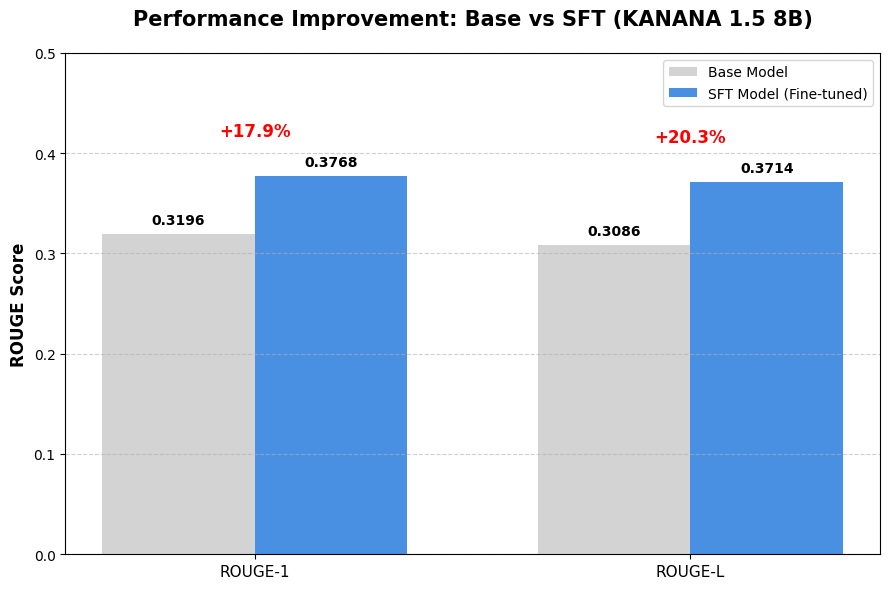

✅ 시각화 리포트(performance_report.png)가 성공적으로 저장되었습니다.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. 실제 측정 데이터 입력
metrics = ['ROUGE-1', 'ROUGE-L']
base_scores = [0.3196, 0.3086]
sft_scores = [0.3768, 0.3714]

# 데이터프레임 생성
df = pd.DataFrame({
    'Metric': metrics,
    'Base Model': base_scores,
    'SFT Model': sft_scores
})

# 2. 그래프 시각화 설정
plt.figure(figsize=(10, 7))
x = np.arange(len(metrics))
width = 0.35

# 막대 그리기
fig, ax = plt.subplots(figsize=(9, 6))
rects1 = ax.bar(x - width/2, base_scores, width, label='Base Model', color='#D3D3D3') # 연한 회색
rects2 = ax.bar(x + width/2, sft_scores, width, label='SFT Model (Fine-tuned)', color='#4A90E2') # 파란색

# 텍스트 및 라벨 추가
ax.set_ylabel('ROUGE Score', fontsize=12, fontweight='bold')
ax.set_title('Performance Improvement: Base vs SFT (KANANA 1.5 8B)', fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.set_ylim(0, 0.5) # 점수 범위에 맞춰 조절
ax.legend()

# 막대 위에 수치 표시하는 함수
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # 5포인트 위로 띄움
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

# 향상률 표시 (화살표나 텍스트로 강조)
for i in range(len(metrics)):
    improvement = ((sft_scores[i] - base_scores[i]) / base_scores[i]) * 100
    ax.text(i, max(sft_scores[i], base_scores[i]) + 0.04,
            f'+{improvement:.1f}%', ha='center', color='red', fontweight='bold', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# 3. 결과 저장 및 출력
plt.savefig('performance_report.png', dpi=300) # 고해상도 저장
plt.show()

print("✅ 시각화 리포트(performance_report.png)가 성공적으로 저장되었습니다.")